In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import r2_score, mean_squared_error
import theano.tensor as tt
from theano import shared
import pandas as pd
from pandas.plotting import scatter_matrix
from tqdm import tqdm
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [334]:
tqdm.monitor_interval = 0

In [111]:
class PyMCModel:
    def __init__(self, model, X, y, model_name='None'):
        self.model = model(X, y)
        self.model.name = model_name
        
    def fit(self, n_samples=2000):
        with self.model:
            self.trace_ = pm.sample(n_samples)
    
    def fit_ADVI(self, n_samples=2000, n_iter=100000, inference='advi'):
        with self.model:
            approx_fit = pm.fit(n=n_iter, method=inference)
            self.trace_ = approx_fit.sample(draws=n_samples)
    
    def show_model(self):
        return pm.model_to_graphviz(self.model)
    
    def predict(self, X, w_index=[]):
        ws = self.trace_['w'].T
        if len(w_index)>0:
            ws = ws[w_index]
        return X.dot(ws) + self.trace_['alpha']
    
    def evaluate_fit(self, show_feats):
        return pm.traceplot(self.trace_, varnames=show_feats)
    
    def show_forest(self, show_feats, feat_labels=None):
        g = pm.forestplot(self.trace_, varnames=show_feats,
                             ylabels=feat_labels)
        f = pl.gcf()
        ax = f.get_axes()[1]
        ax.grid(axis='y')
        return g
    
    def plot_model_fits(self, y_obs, title=None, ax=None):
        y_model = self.trace_.get_values('mu')
        y_model_mean = np.mean(y_model, axis=0)
        y_model_hpd = pm.hpd(y_model)
        ppc_y = pm.sample_ppc(self.trace_, model=self.model)['y']
        ppc_y_mean = ppc_y.mean(axis=0)
        hpd = pm.hpd(ppc_y)
        try:
            rmse = np.sqrt(mean_squared_error(y_obs, y_model_mean))
        except ValueError:
            mask = np.isnan(y_obs)
            y_model_mean = np.ma.array(data=y_model_mean, mask=mask).compressed()
            y_obs = np.ma.array(data=y_obs, mask=mask).compressed()
        finally:    
            r2 = r2_score(y_obs, y_model_mean)
            rmse = np.sqrt(mean_squared_error(y_obs, y_model_mean))
        if ax is None:
            _, ax = pl.subplots(figsize=(10, 10),)# nrows=2)
        ax.set_title('Model Fit')
        ax.set_xlabel('modeled')
        ax.set_ylabel('observed')
        ax.scatter(y_model_mean, y_obs, color='k', alpha=0.5,
                     label='$log_{10}(chl)$, $r^2=%.2f$, rmse=%.2f' %(r2, rmse));
        ax.plot([-1.5, 1.5], [-1.5, 1.5], 'k--', label='1:1')
        ax.axis('equal')
        ax.legend(loc='best')
        """ix = np.argsort(y_obs.ravel())
        xi = np.arange(y_obs.size)
        ax[1].set_title('Posterior Predictive Checks')
        ax[1].set_xlabel('obs #')
        ax[1].set_ylabel('$log_{10}(chl)$')
        ax[1].plot(y_obs.ravel()[ix], ls='', marker='.', color='k', label='Obs')
        ax[1].plot(ppy_y_mean[ix], ls='', color='r', marker='o', markersize=10,
                   alpha=0.7, label='PPC mean')
        ax[1].fill_between(xi, hpd[ix, 0], hpd[ix, 1], color='orange',
                           alpha=0.3, label='PPC 95% Cred. Int.');
        ax[1].legend(loc='best');"""
        f = pl.gcf()
        f.suptitle(title, y=1.01);
        f.tight_layout()
        return ax

In [321]:
hi, lo = 100*(1-0.1/2), 100 * (0.1/2)

In [323]:
if str(hi).split('.')[1] == '0':
    print(str(int(hi)))

95


In [324]:
def hs_regression(X, y_obs, ylabel='y', tau_0=None, regularized=False, **kwargs):
    """See Piironen & Vehtari, 2017 (DOI: 10.1214/17-EJS1337SI)"""
    if tau_0 is None:
        M = X.shape[1]
        m0 = M/2
        N = X.shape[0]
        tau_0 = m0 / ((M - m0) * np.sqrt(N))
    if regularized:
        slab_scale = kwargs.pop('slab_scale', 3)
        slab_scale_sq = slab_scale ** 2
        slab_df = kwargs.pop('slab_df', 8)
        half_slab_df = slab_df / 2
        with pm.Model() as mhsr:
            tau = pm.HalfCauchy('tau', tau_0)
            c_sq = pm.InverseGamma('c_sq', alpha=half_slab_df,
                                   beta=half_slab_df * slab_scale_sq)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            lamb_m_bar = tt.sqrt(c_sq) * lamb_m / (tt.sqrt(c_sq + 
                                                           tt.pow(tau, 2) *
                                                           tt.pow(lamb_m, 2)
                                                          )
                                                  )
            w = pm.Normal('w', mu=0, sd=tau*lamb_m_bar, shape=X.shape[1])
            mu_ = pm.Deterministic('mu', tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhsr
    else:
        with pm.Model() as mhs:
            tau = pm.HalfCauchy('tau', tau_0)
            lamb_m = pm.HalfCauchy('lambda_m', beta=1)
            w = pm.Normal('w', mu=0, sd = tau*lamb_m, shape=X.shape[1])
            mu_ = pm.Deterministic('mu', tt.dot(X, w))
            sig = pm.HalfCauchy('sigma', beta=10)
            y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
        return mhs

    
def lasso_regression(X, y_obs, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=0, b=sd_beta)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso


def lasso_regr_impute_y(X, y_obs, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlass_y_na:
        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=0, b=sd_beta)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        mu_y_obs = pm.Normal('mu_y_obs', 0.5, 1)
        sigma_y_obs = pm.HalfCauchy('sigma_y_obs', 1)
        y_obs_ = pm.Normal('y_obs', mu_y_obs, sigma_y_obs, observed=y_obs.squeeze())
        y = pm.Normal('y', mu=y_obs_, sd=sig)
    return mlass_y_na


def hier_lasso_regr(X, y_obs, add_bias=True, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        hyp_beta = pm.HalfCauchy('hyp_beta', beta=2.5)
        hyp_mu = pm.HalfCauchy('hyp_mu', mu=0, beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=hyp_mu, b=hyp_beta)
        w = pm.Laplace('w', mu=hyp_mu, b=hyp_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso


def subset_significant_feature(trace, labels_list, beg_feat, alpha=0.05, vars_=None):
    if vars_ is None:
        vars_ = ['sd_beta', 'sigma', 'alpha', 'w']
    dsum = pm.summary(trace, varnames=vars_, alpha=alpha)
    lbls_list = ['w[%s]' %lbl for lbl in labels_list]
    dsum.index = vars_[:-1] + lbls_list 
    hpd_lo, hpd_hi = 100 * (alpha / 2), 100 * (1 - alpha / 2)
    if str(hpd_lo).split('.')[1] == '0':
        hpd_lo = int(hpd_lo)
    if str(hpd_hi).split('.')[1] == '0':
        hpd_hi = int(hpd_hi)
    dsum_subset = dsum[(((dsum[f'hpd_{hpd_lo}']<0)&(dsum[f'hpd_{hpd_hi}']<0))|
                    ((dsum[f'hpd_{hpd_lo}']>0) & (dsum[f'hpd_{hpd_hi}']>0))
                   )]
    pattern1 = r'w\s*\[([a-z_\sA-Z0-9]+)\]'
    return list(dsum_subset.index.str.extract(pattern1).dropna().values.flatten())


#def biome_hier_regression(X, y_obs, add_bias=True, ylabel='y'):
#    if add_bias:
#        X = np.c_[np.ones((X.shape[0],)), X]
#    with pm.Model() as mbhlasso:
#        sd_beta = pm.HalfCauchy('sd_beta', beta=2.5)
#        wh = 

def Plot_Model_Fits(trace, model, title=None, ax=None):
    mu_log10chl = trace.get_values('mu')
    mu_log10chl_mean = np.median(mu_log10chl, axis=0)

    mu_hpd = pm.hpd(mu_log10chl)

    ppc_y = pm.sample_ppc(trace, model=model)['y']
    mn = ppc_y.mean(axis=0)
    hpd = pm.hpd(ppc_y)
    rmse = np.sqrt(mean_squared_error(y, mu_log10chl_mean))
    r2 = r2_score(y, mu_log10chl_mean)
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 18), nrows=2)
    ax[0].set_title('Model Fit')
    ax[0].set_xlabel('modeled')
    ax[0].set_ylabel('observed')
    ax[0].scatter(mu_log10chl_mean, y, color='k', alpha=0.5,
                 label='$log_{10}(chl)$, $r^2=%.2f$, rmse=%.2f' %(r2, rmse));
    ax[0].plot([-1.5, 1.5], [-1.5, 1.5], 'k--', label='1:1')
    ax[0].axis('equal')
    ax[0].legend(loc='best')
    ix = np.argsort(y.ravel())
    xi = np.arange(y.size)
    ax[1].set_title('Posterior Predictive Checks')
    ax[1].set_xlabel('obs #')
    ax[1].set_ylabel('$log_{10}(chl)$')
    ax[1].plot(y.ravel()[ix], ls='', marker='.', color='k', label='Obs')
    ax[1].plot(mn[ix], ls='', color='r', marker='o', markersize=10,
               alpha=0.7, label='PPC mean')
    ax[1].fill_between(xi, hpd[ix, 0], hpd[ix, 1], color='orange',
                       alpha=0.3, label='PPC 95% Cred. Int.');
    ax[1].legend(loc='best');
    f = pl.gcf()
    f.suptitle(title, y=1.01);
    f.tight_layout()
    return ax

In [130]:
ds = pd.read_pickle('./pickleJar/df_rs_6_FullSet_noInteractions.pkl')
dps = pd.read_pickle('./pickleJar/df_rs_6_FullSet_MaxInteractions.pkl')
dpcapoly_s = pd.read_pickle('./pickleJar/df_rs_6_FullSet_PCAInteractions.pkl')

In [131]:
ds.head().T

0                   1  \
Biome                                      Westerlies               Polar   
BiomCat                                             3                   1   
Province        Mediterranean Sea, Black Sea Province  Antarctic Province   
ProvCode                                         MEDI                ANTA   
Coastal                                             0                   0   
ProvCat                                            42                  22   
sin_doy                                     -0.984474            0.790946   
cos_doy                                      0.175531            0.611886   
sin_minofday                                 0.601815           -0.965926   
cos_minofday                                -0.798636           -0.258819   
x                                            0.700808            0.222167   
y                                            0.328432           -0.423148   
z                                            0.633246             -0.8784   
log10_etopo2_s                               0.334586            0.962905   
oisst_s                                   -0.00266548            -1.51577   
solz_s                                       0.747153            0.861048   
PC1_s                                        0.450843            0.934552   
PC2_s                                       -0.528003           -0.419699   
PC3_s                                       -0.594129           -0.646996   
PC4_s                                        0.113778           -0.566777   
PC5_s                                       -0.896284            -1.10572   
PC6_s                                        0.453029            0.394948   
log10_chl                                    -1.04096           -0.928118   

                                     2                       3  \
Biome                            Polar                   Polar   
BiomCat                              1                       1   
Province        Austral Polar Province  Austral Polar Province   
ProvCode                          APLR                    APLR   
Coastal                              0                       0   
ProvCat                             25                      25   
sin_doy                       0.758306                0.369725   
cos_doy                       0.651899                0.929141   
sin_minofday                 -0.887011               -0.442289   
cos_minofday                 -0.461749               -0.896873   
x                             0.266604                0.267607   
y                            -0.399605               -0.404279   
z                            -0.877062               -0.874611   
log10_etopo2_s                0.230894                0.814552   
oisst_s                       -1.67215                -1.58241   
solz_s                        0.929385                 0.61959   
PC1_s                         0.982326                 1.06837   
PC2_s                         0.564757                0.364925   
PC3_s                         0.430704               0.0828478   
PC4_s                          1.39032                 0.59479   
PC5_s                         0.479462               -0.184703   
PC6_s                          1.33098                0.936472   
log10_chl                          NaN               -0.211832   

                                                         4  
Biome                                               Trades  
BiomCat                                                  2  
Province        N. Atlantic Tropical Gyral Province (Trpg)  
ProvCode                                              NATR  
Coastal                                                  0  
ProvCat                                                 33  
sin_doy                                          -0.997917  
cos_doy                                         -0.0645084  
sin_minofday                                      0.134851  
cos_mino

In [132]:
feat_beg = 'sin_doy'
feat_end_ni = 'PC6_s'
feat_end_wi = 'PC5_s PC6_s'
X_s = ds.dropna().loc[:, feat_beg: feat_end_ni].values
X_s_na = ds.loc[:, feat_beg: feat_end_ni].values
lbls_X_s = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
Xp_s = dps.dropna().loc[:, feat_beg: feat_end_wi].values
lbls_Xp_s = dps.loc[:, feat_beg: feat_end_wi].columns.tolist()
Xp_s_na = dps.loc[:, feat_beg: feat_end_wi].values
Xpcap_s = dpcapoly_s.dropna().loc[:, feat_beg: feat_end_wi].values
lbls_Xpcap_s = dpcapoly_s.loc[:, feat_beg: feat_end_wi].columns.tolist()
Xpcap_s_na = dpcapoly_s.loc[:, feat_beg: feat_end_wi].values
y = ds.dropna().log10_chl
y_na = ds.log10_chl

### <u>No Interactions</u>
<br>
#### <u>1. Fitting with NaNs dropped (no imputations)</u>

In [133]:
m_lasso_ = PyMCModel(lasso_regression, X_s, y, model_name='lasso_no_imp')
m_lasso_.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:08<00:00, 1177.09draws/s]


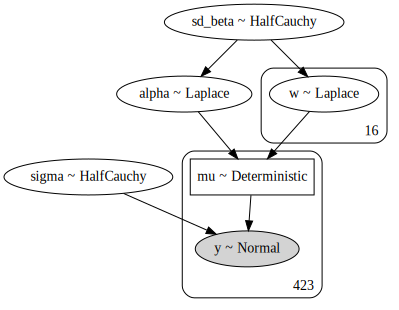

In [134]:
m_lasso_.show_model()

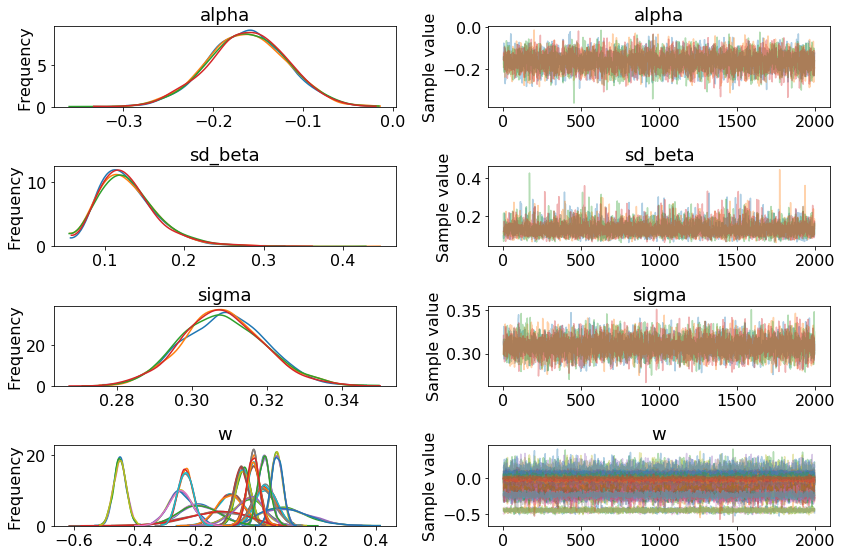

In [135]:
vars_ = ['alpha', 'sd_beta', 'sigma', 'w',]
m_lasso_.evaluate_fit(show_feats=vars_);

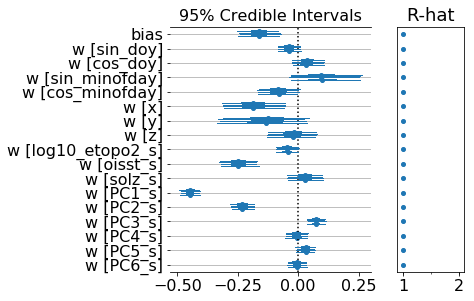

In [136]:
lbls = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lbls]
m_lasso_.show_forest(['alpha', 'w'], feat_labels=lbls_list);

100%|██████████| 2000/2000 [00:01<00:00, 1627.01it/s]


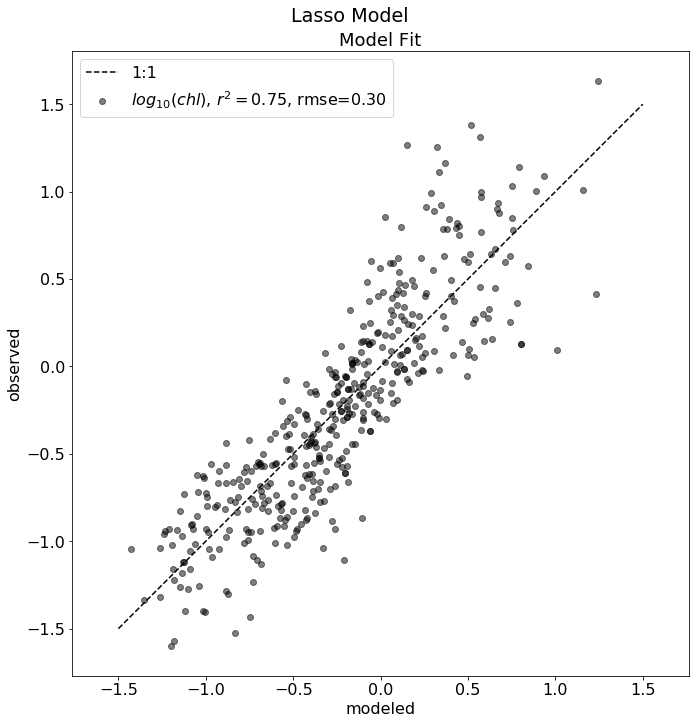

In [137]:
ax0 = m_lasso_.plot_model_fits(y_obs=y, title='Lasso Model')

#### <u>2. with missing data imputation</u> 

In [138]:
m_lasso_na_ = PyMCModel(lasso_regression, X_s_na, y_na, model_name='lasso_w_imp')
m_lasso_na_.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, w, alpha, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:12<00:00, 805.21draws/s]


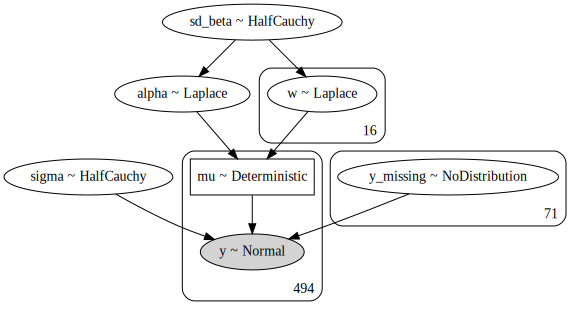

In [139]:
m_lasso_na_.show_model()

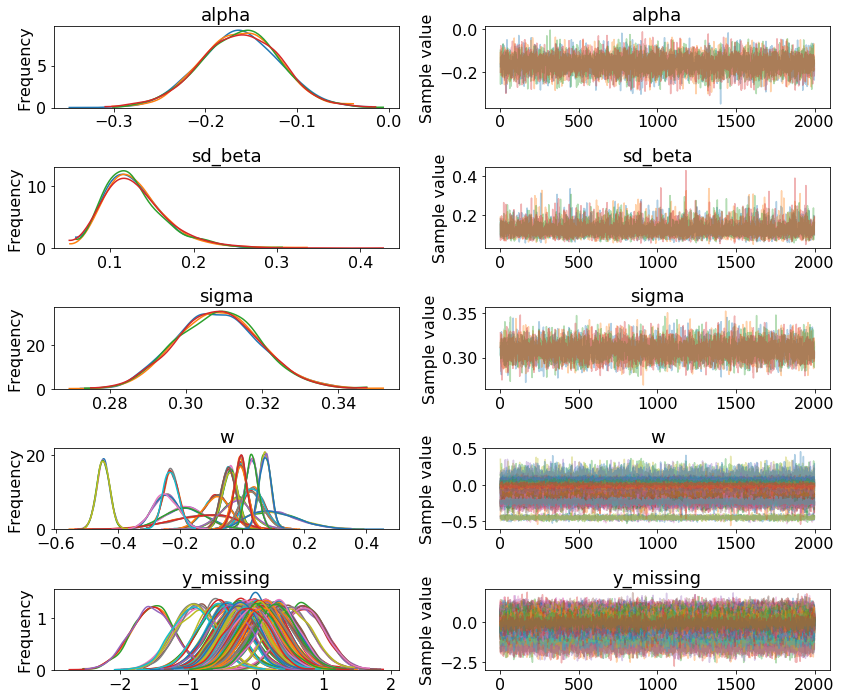

In [140]:
vars_na_ = vars_ + ['y_missing']
m_lasso_na_.evaluate_fit(vars_na_);

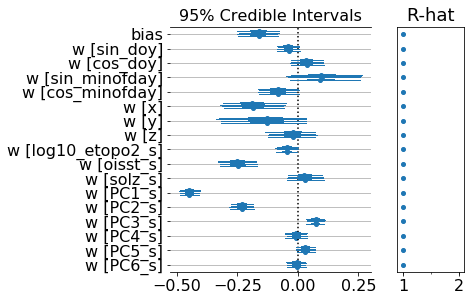

In [141]:
lbls = ds.loc[:, feat_beg: feat_end_ni].columns.tolist()
lbls_list = ['bias'] + ['w [%s]' % lbl for lbl in lbls]
m_lasso_na_.show_forest(['alpha', 'w'], feat_labels=lbls_list);

100%|██████████| 2000/2000 [00:01<00:00, 1635.63it/s]


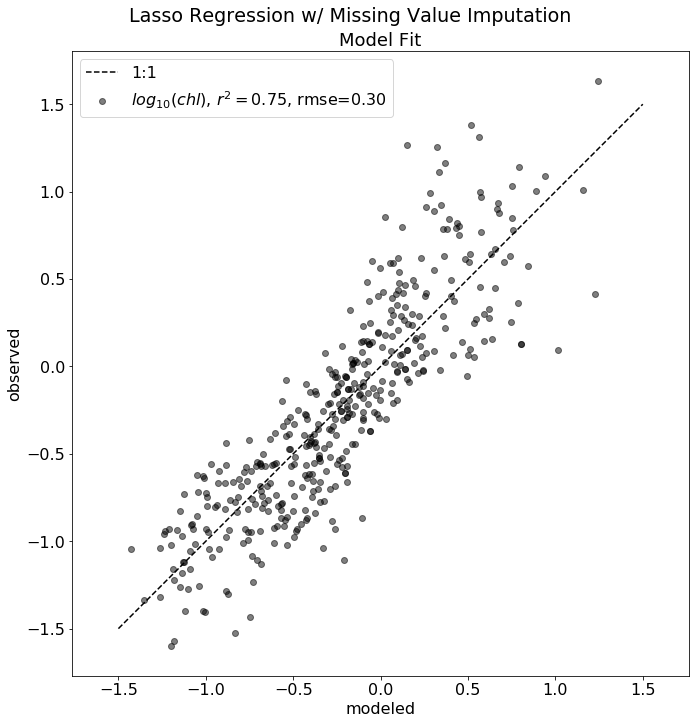

In [142]:
m_lasso_na_.plot_model_fits(y_obs=y_na,
                            title='Lasso Regression w/ Missing Value Imputation');

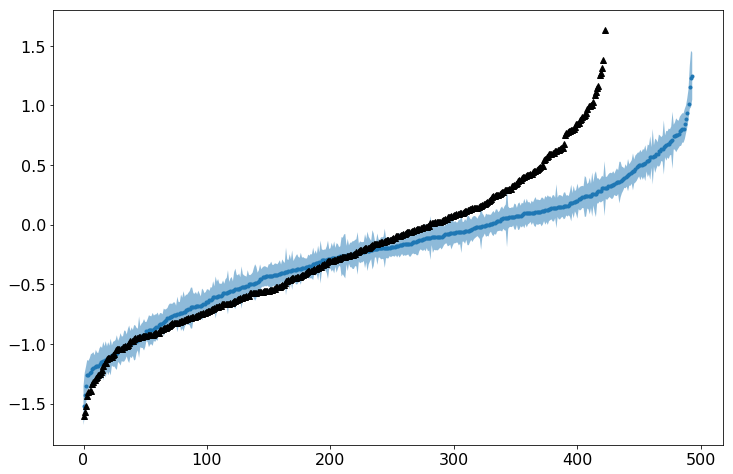

In [143]:
pred = m_lasso_na_.predict(X_s_na).T
pred_mean = pred.mean(axis=0)
hp = pm.hpd(pred)
ix = np.argsort(pred_mean)
xi = np.arange(pred_mean.size)
y_na_ma = np.ma.array(data=y_na, mask=np.isnan(y_na)).compressed()
y_namaix = np.argsort(y_na_ma)
xi_yna = np.arange(y_namaix.size)

pl.figure(figsize=(12, 8))
pl.plot(xi, pred_mean[ix], marker='.', ls='')
pl.plot()
pl.fill_between(xi, hp[ix,0], hp[ix, 1], alpha=0.5)
pl.plot(xi_yna, y_na_ma[y_namaix], marker='^', ls='', color='k')

<u>Discover significant_features</u>

In [283]:
lasso_sub_feats = subset_significant_feature(m_lasso_na_.trace_,
                                             lbls_X_s, beg_feat=feat_beg)

In [288]:
lasso_sub_feats

['x', 'oisst_s', 'PC1_s', 'PC2_s', 'PC3_s']

#### <u>3. With missing value imputation and subsetting of "significant features</u>

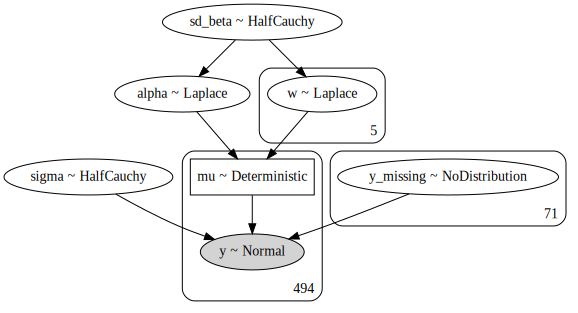

In [286]:
X_na_sub = ds.loc[:, lasso_sub_feats].values
mlasso_sub = PyMCModel(lasso_regression, X_na_sub, y_na,
                       model_name='lasso_regr_sub_w_imp')
mlasso_sub.show_model()

In [287]:
mlasso_sub.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, w, alpha, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:05<00:00, 1729.48draws/s]


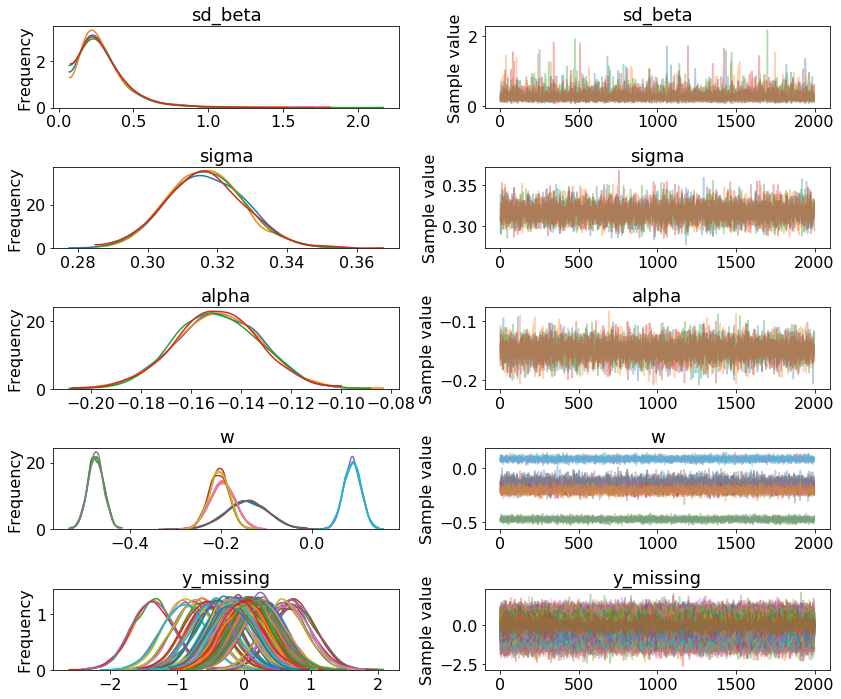

In [291]:
vars_ = ['sd_beta', 'sigma', 'alpha', 'w', 'y_missing']
mlasso_sub.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1695.00it/s]


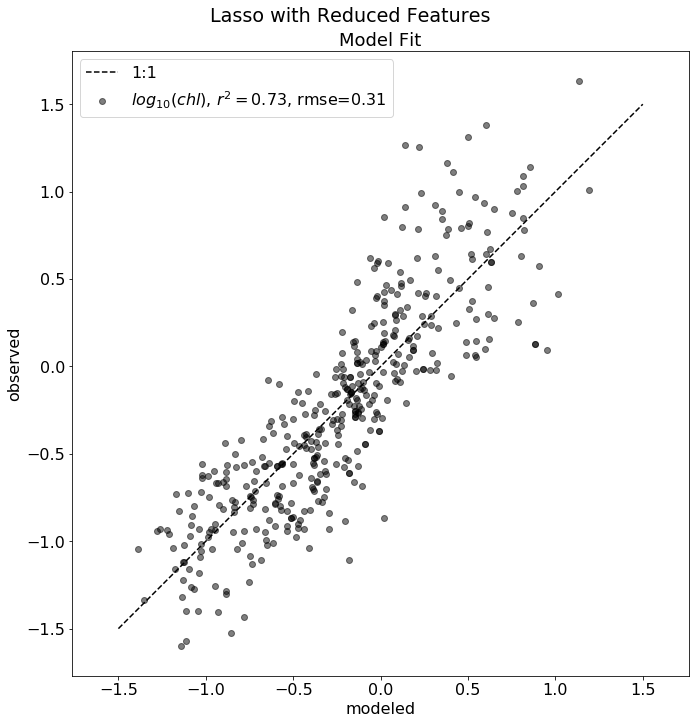

In [293]:

mlasso_sub.plot_model_fits(y_na, title='Lasso with Reduced Features');

### Modeling with Maximum Feature Interactions

#### <u>1. No missing value imputation</u>

In [294]:
mp_lasso = PyMCModel(lasso_regression, Xp_s, y, model_name='lasso_w_max_interactions')

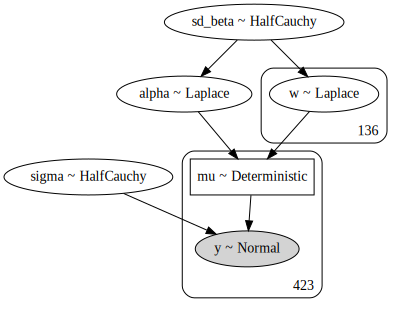

In [295]:
mp_lasso.show_model()

In [296]:
mp_lasso.fit_ADVI()

Average Loss = 113.86: 100%|██████████| 100000/100000 [00:49<00:00, 2034.37it/s]
Finished [100%]: Average Loss = 113.76


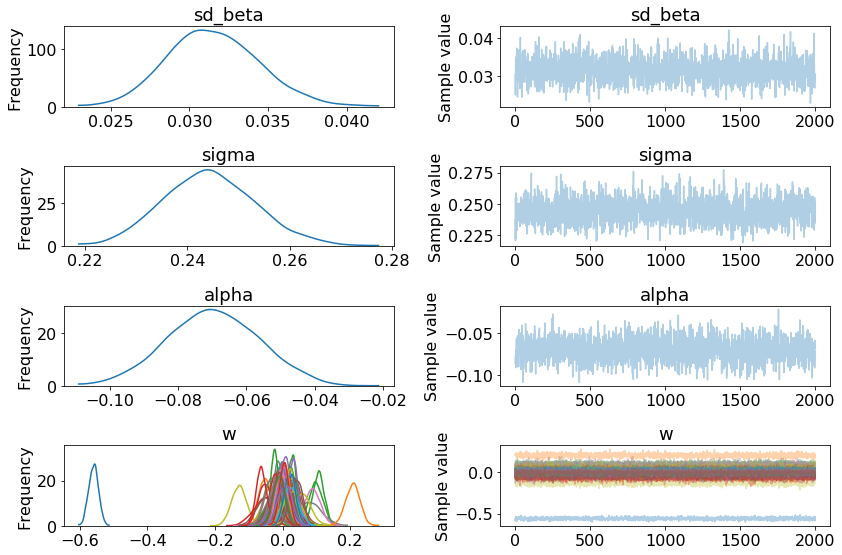

In [298]:
vars_ =['sd_beta', 'sigma', 'alpha', 'w']
mp_lasso.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1543.99it/s]


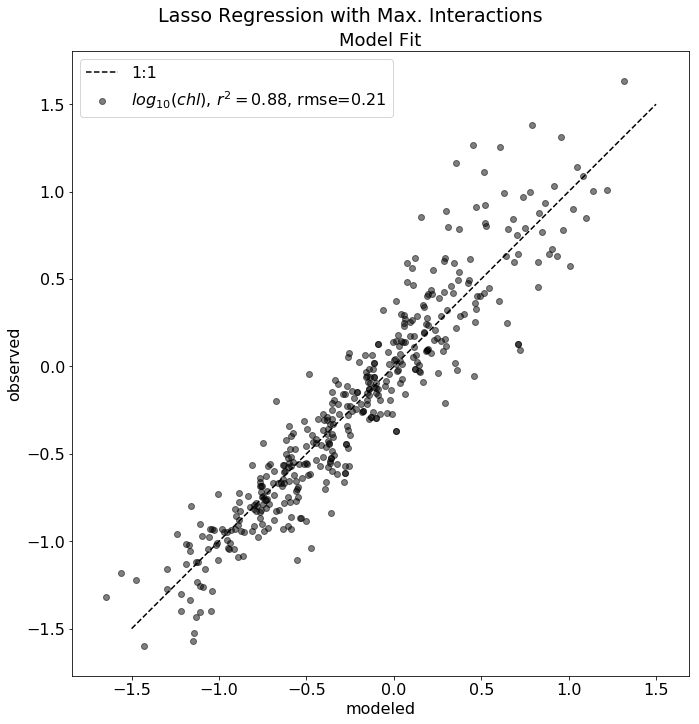

In [299]:
mp_lasso.plot_model_fits(y, title='Lasso Regression with Max. Interactions');

#### <u>2. with missing data imputation</u>

In [300]:
mp_lasso_na = PyMCModel(lasso_regression, Xp_s_na, y_na, 
                        model_name='lasso_w_max_inter_&_imp')

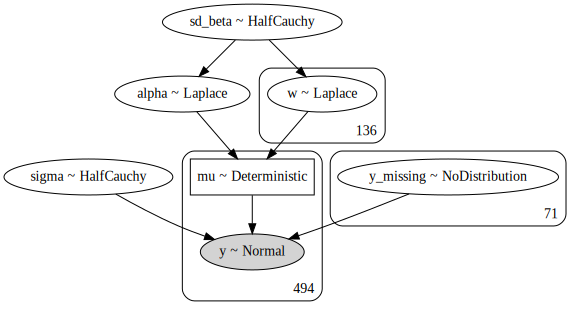

In [301]:
mp_lasso_na.show_model()

In [302]:
mp_lasso_na.fit_ADVI()

Average Loss = 122.07: 100%|██████████| 100000/100000 [00:54<00:00, 1826.71it/s]
Finished [100%]: Average Loss = 122.08


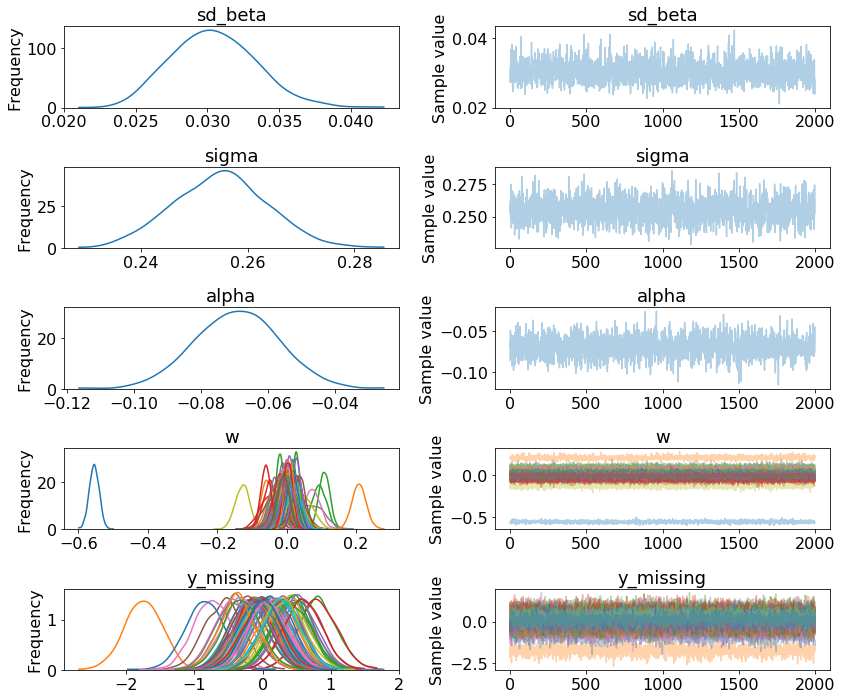

In [304]:
vars_ = vars_ =['sd_beta', 'sigma', 'alpha', 'w', 'y_missing']
mp_lasso_na.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1484.49it/s]


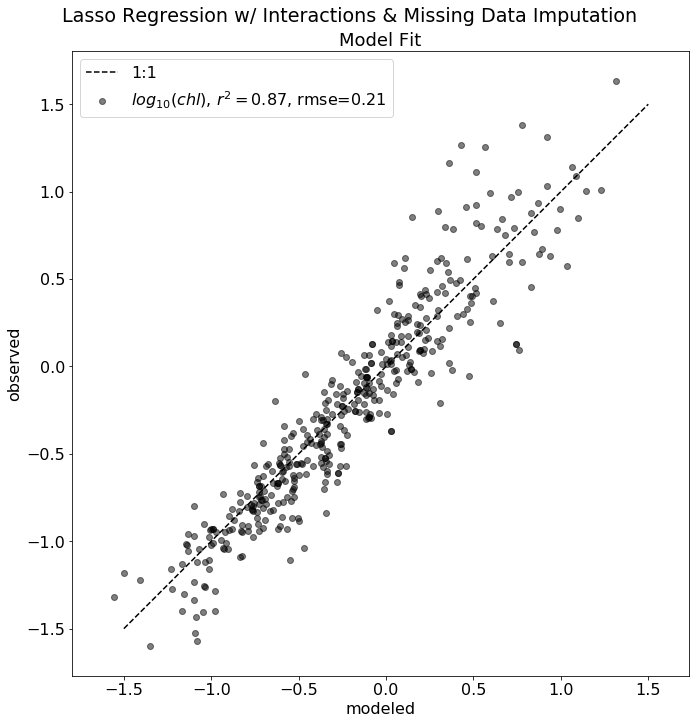

In [305]:
mp_lasso_na.plot_model_fits(y_na, title='Lasso Regression w/ Interactions & Missing Data Imputation');

#### <u>3. Subset significant features </u>

In [325]:
lasso_inter_sub_feats = subset_significant_feature(mp_lasso_na.trace_, 
                                                    lbls_Xp_s, feat_beg, alpha=0.1)

In [326]:
lasso_inter_sub_feats

['oisst_s',
 'PC1_s',
 'PC2_s',
 'PC3_s',
 'PC4_s',
 'sin_doy log10_etopo2_s',
 'cos_doy sin_minofday',
 'cos_doy PC5_s',
 'sin_minofday y',
 'x PC3_s',
 'y PC2_s',
 'log10_etopo2_s PC1_s',
 'log10_etopo2_s PC2_s',
 'log10_etopo2_s PC4_s',
 'log10_etopo2_s PC6_s',
 'oisst_s solz_s',
 'PC1_s PC2_s',
 'PC1_s PC3_s',
 'PC1_s PC4_s',
 'PC1_s PC5_s',
 'PC1_s PC6_s']

In [327]:
Xp_s_na_sub = dps.loc[:, lasso_inter_sub_feats].values
mp_lasso_na_sub = PyMCModel(lasso_regression, Xp_s_na_sub, y_na, 
                            model_name='lasso_regr_w_sub_inter_&_imp.')

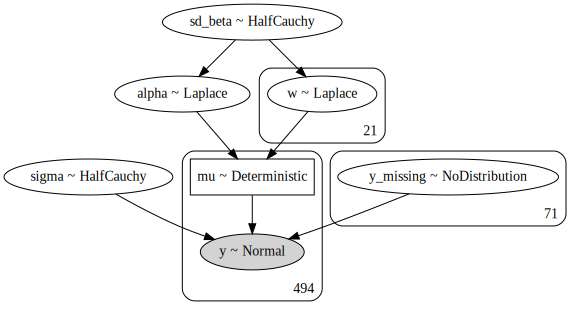

In [328]:
mp_lasso_na_sub.show_model()

In [330]:
mp_lasso_na_sub.fit_ADVI()


Average Loss = 1,342.3:   0%|          | 331/100000 [00:00<01:27, 1140.69it/s]


Average Loss = 1,318.5:   1%|          | 972/100000 [00:00<01:02, 1585.78it/s]


Average Loss = 1,238:   1%|▏         | 1351/100000 [00:00<01:04, 1537.35it/s]


Average Loss = 1,164.4:   2%|▏         | 1781/100000 [00:01<01:02, 1564.73it/s]


Average Loss = 1,113.9:   2%|▏         | 2384/100000 [00:01<00:58, 1674.18it/s]


Average Loss = 1,078.6:   3%|▎         | 2761/100000 [00:01<00:59, 1629.90it/s]


Average Loss = 1,023.7:   3%|▎         | 3323/100000 [00:01<00:56, 1698.88it/s]


Average Loss = 972.82:   4%|▎         | 3701/100000 [00:02<00:59, 1630.65it/s]


Average Loss = 937.92:   4%|▍         | 4251/100000 [00:02<00:59, 1614.34it/s]


Average Loss = 896.64:   5%|▍         | 4736/100000 [00:02<00:59, 1604.77it/s]


Average Loss = 856.33:   5%|▌         | 5289/100000 [00:03<00:58, 1629.40it/s]


Average Loss = 826.35:   6%|▌         | 5657/100000 [00:03<00:58, 1600.89it/s]


Average Loss = 797.89:   6%|▌         | 6233/100000 [00:03<00:57, 1643.91it/s]


Average Loss = 761.93:   7%|▋         | 6631/100000 [00:04<00:58, 1608.21it/s]


Average Loss = 732.71:   7%|▋         | 7195/100000 [00:04<00:56, 1644.05it/s]


Average Loss = 703.72:   8%|▊         | 7670/100000 [00:04<00:55, 1667.86it/s]


Average Loss = 675.01:   8%|▊         | 8082/100000 [00:04<00:55, 1661.08it/s]


Average Loss = 657.69:   8%|▊         | 8498/100000 [00:05<00:54, 1674.57it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 566.51:  10%|▉         | 9991/100000 [00:05<00:53, 1669.31it/s]


Average Loss = 540.93:  10%|█         | 10391/100000 [00:06<00:53, 1670.69it/s]


Average Loss = 515.75:  11%|█         | 10987/100000 [00:06<00:53, 1679.31it/s]


Average Loss = 492.46:  11%|█▏        | 11491/100000 [00:06<00:52, 1682.37it/s]


Average Loss = 467.74:  12%|█▏        | 12001/100000 [00:07<00:52, 1685.50it/s]


Average Loss = 445.06:  12%|█▏        | 12360/100000 [00:07<00:52, 1673.90it/s]


Average Loss = 424.97:  13%|█▎        | 12893/100000 [00:07<00:51, 1683.07it/s]


Average Loss = 403.44:  13%|█▎        | 13441/100000 [00:07<00:51, 1695.04it/s]


Average Loss = 382:  14%|█▍        | 13841/100000 [00:08<00:50, 1695.19it/s]   


Average Loss = 361.14:  14%|█▍        | 14321/100000 [00:08<00:50, 1711.12it/s]


Average Loss = 342.16:  15%|█▍        | 14767/100000 [00:08<00:49, 1709.57it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 274.62:  16%|█▋        | 16471/100000 [00:09<00:49, 1683.09it/s]


Average Loss = 258.75:  17%|█▋        | 16943/100000 [00:10<00:49, 1678.76it/s]


Average Loss = 241.37:  17%|█▋        | 17485/100000 [00:10<00:49, 1682.91it/s]


Average Loss = 226.34:  18%|█▊        | 18010/100000 [00:10<00:48, 1687.36it/s]


Average Loss = 211.41:  19%|█▊        | 18511/100000 [00:10<00:48, 1689.07it/s]


Average Loss = 194.48:  19%|█▉        | 18838/100000 [00:11<00:48, 1674.04it/s]


Average Loss = 182.12:  19%|█▉        | 19353/100000 [00:11<00:48, 1677.12it/s]


Average Loss = 171.15:  20%|█▉        | 19861/100000 [00:11<00:47, 1679.63it/s]


Average Loss = 158.45:  20%|██        | 20353/100000 [00:12<00:47, 1678.27it/s]


Average Loss = 146.76:  21%|██        | 20837/100000 [00:12<00:47, 1677.08it/s]


Average Loss = 135.77:  21%|██▏       | 21316/100000 [00:12<00:46, 1675.05it/s]


Average Loss = 126.15:  22%|██▏       | 21817/100000 [00:13<00:46, 1676.02it/s]


Average Loss = 117.63:  22%|██▏       | 22198/100000 [00:13<00:46, 1670.99it/s]


Average Loss = 110.49:  23%|██▎       | 22737/100000 [00:13<00:46, 1673.35it/s]


Average Loss = 103.65:  23%|██▎       | 23232/100000 [00:13<00:45, 1674.03it/s]


Average Loss = 97.166:  24%|██▎       | 23672/100000 [00:14<00:45, 1679.56it/s]


Average Loss = 91.207:  24%|██▍       | 24146/100000 [00:14<00:44, 1689.66it/s]


Average Loss = 86.416:  25%|██▍       | 24628/100000 [00:14<00:44, 1698.84it/s]


Average Loss = 81.893:  25%|██▌       | 25077/100000 [00:14<00:44, 1701.55it/s]


Average Loss = 77.584:  26%|██▌       | 25511/100000 [00:14<00:43, 1705.80it/s]


Average Loss = 74.947:  26%|██▌       | 25958/100000 [00:15<00:43, 1698.14it/s]


Average Loss = 72.535:  26%|██▋       | 26499/100000 [00:15<00:43, 1703.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


Average Loss = 66.683:  28%|██▊       | 27808/100000 [00:16<00:42, 1693.44it/s]


Average Loss = 65.304:  28%|██▊       | 28271/100000 [00:16<00:42, 1699.89it/s]


Average Loss = 63.761:  29%|██▊       | 28722/100000 [00:16<00:41, 1704.68it/s]


Average Loss = 62.37:  29%|██▉       | 29391/100000 [00:17<00:41, 1720.66it/s] 


Average Loss = 61.444:  30%|██▉       | 29839/100000 [00:17<00:40, 1723.76it/s]


Average Loss = 60.803:  30%|███       | 30260/100000 [00:17<00:40, 1721.81it/s]


Average Loss = 60.529:  31%|███       | 30711/100000 [00:17<00:40, 1725.80it/s]


Average Loss = 60.103:  31%|███       | 31152/100000 [00:18<00:39, 1725.78it/s]


Average Loss = 59.94:  32%|███▏      | 31726/100000 [00:18<00:39, 1725.43it/s]


Average Loss = 59.52:  32%|███▏      | 32216/100000 [00:18<00:39, 1722.53it/s] 


Average Loss = 59.126:  33%|███▎      | 32698/100000 [00:19<00:39, 1720.05it/s]


Average Loss = 58.72:  33%|███▎      | 33041/100000 [00:19<00:39, 1714.44it/s]


Average Loss = 58.489:  34%|███▎      | 33649/100000 [00:19<00:38, 1724.49it/s]


Average Loss = 58.486:  34%|███▍      | 34032/100000 [00:19<00:38, 1719.99it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


Average Loss = 58.27:  36%|███▌      | 35531/100000 [00:20<00:37, 1729.45it/s]


Average Loss = 57.845:  36%|███▌      | 35983/100000 [00:20<00:36, 1732.23it/s]


Average Loss = 57.814:  36%|███▋      | 36425/100000 [00:21<00:36, 1733.46it/s]


Average Loss = 57.836:  37%|███▋      | 36833/100000 [00:21<00:36, 1731.28it/s]


Average Loss = 57.742:  37%|███▋      | 37261/100000 [00:21<00:36, 1731.04it/s]


Average Loss = 57.698:  38%|███▊      | 37921/100000 [00:21<00:35, 1742.21it/s]


Average Loss = 57.717:  38%|███▊      | 38345/100000 [00:22<00:35, 1742.00it/s]


Average Loss = 57.729:  39%|███▉      | 38781/100000 [00:22<00:35, 1742.48it/s]


Average Loss = 57.706:  39%|███▉      | 39371/100000 [00:22<00:34, 1746.87it/s]


Average Loss = 57.708:  40%|███▉      | 39746/100000 [00:22<00:34, 1741.98it/s]


Average Loss = 57.566:  40%|████      | 40114/100000 [00:23<00:34, 1734.31it/s]


Average Loss = 57.574:  40%|████      | 40338/100000 [00:23<00:34, 1743.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


Average Loss = 57.926:  42%|████▏     | 42161/100000 [00:24<00:33, 1746.29it/s]


Average Loss = 57.727:  43%|████▎     | 42565/100000 [00:24<00:32, 1741.87it/s]


Average Loss = 57.466:  43%|████▎     | 43131/100000 [00:24<00:32, 1745.00it/s]


Average Loss = 57.156:  43%|████▎     | 43473/100000 [00:25<00:32, 1738.17it/s]


Average Loss = 57.268:  44%|████▍     | 44098/100000 [00:25<00:32, 1744.77it/s]


Average Loss = 57.488:  45%|████▍     | 44521/100000 [00:25<00:31, 1744.32it/s]


Average Loss = 57.609:  45%|████▌     | 45118/100000 [00:25<00:31, 1749.94it/s]


Average Loss = 57.456:  45%|████▌     | 45488/100000 [00:26<00:31, 1747.31it/s]


Average Loss = 57.383:  46%|████▌     | 45894/100000 [00:26<00:30, 1746.49it/s]


Average Loss = 57.3:  47%|████▋     | 46531/100000 [00:26<00:30, 1754.01it/s]  


Average Loss = 57.375:  47%|████▋     | 46531/100000 [00:26<00:30, 1747.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 57.585:  48%|████▊     | 48340/100000 [00:27<00:29, 1753.69it/s]


Average Loss = 57.475:  49%|████▊     | 48691/100000 [00:27<00:29, 1748.45it/s]


Average Loss = 57.274:  49%|████▉     | 49231/100000 [00:28<00:29, 1750.01it/s]


Average Loss = 57.157:  50%|████▉     | 49615/100000 [00:28<00:28, 1747.82it/s]


Average Loss = 57.33:  50%|█████     | 50167/100000 [00:28<00:28, 1748.31it/s] 


Average Loss = 57.529:  51%|█████     | 50661/100000 [00:29<00:28, 1742.91it/s]


Average Loss = 57.396:  51%|█████     | 51104/100000 [00:29<00:28, 1737.81it/s]


Average Loss = 57.415:  52%|█████▏    | 51559/100000 [00:29<00:27, 1735.47it/s]


Average Loss = 57.679:  52%|█████▏    | 52051/100000 [00:30<00:27, 1734.66it/s]


Average Loss = 57.559:  53%|█████▎    | 52542/100000 [00:30<00:27, 1734.03it/s]


Average Loss = 57.477:  53%|█████▎    | 53012/100000 [00:30<00:27, 1730.73it/s]


Average Loss = 57.524:  53%|█████▎    | 53425/100000 [00:30<00:26, 1729.30it/s]


Average Loss = 57.457:  54%|█████▍    | 53976/100000 [00:31<00:26, 1729.12it/s]


Average Loss = 57.303:  54%|█████▍    | 54459/100000 [00:31<00:26, 1726.58it/s]


Average Loss = 57.397:  55%|█████▍    | 54907/100000 [00:31<00:26, 1722.37it/s]


Average Loss = 57.525:  55%|█████▌    | 55483/100000 [00:32<00:25, 1726.46it/s]


Average Loss = 57.316:  56%|█████▌    | 55821/100000 [00:32<00:25, 1721.49it/s]


Average Loss = 57.171:  56%|█████▋    | 56361/100000 [00:32<00:25, 1723.52it/s]


Average Loss = 57.476:  57%|█████▋    | 56919/100000 [00:32<00:24, 1726.98it/s]


Average Loss = 57.375:  57%|█████▋    | 57296/100000 [00:33<00:24, 1723.29it/s]


Average Loss = 57.217:  58%|█████▊    | 57863/100000 [00:33<00:24, 1723.08it/s]


Average Loss = 57.372:  58%|█████▊    | 58201/100000 [00:33<00:24, 1717.31it/s]


Average Loss = 57.529:  59%|█████▊    | 58728/100000 [00:34<00:24, 1718.52it/s]


Average Loss = 57.493:  59%|█████▉    | 59286/100000 [00:34<00:23, 1720.23it/s]


Average Loss = 57.33:  60%|█████▉    | 59640/100000 [00:34<00:23, 1717.09it/s]


Average Loss = 57.273:  60%|██████    | 60217/100000 [00:35<00:23, 1718.05it/s]


Average Loss = 57.347:  61%|██████    | 60683/100000 [00:35<00:22, 1713.87it/s]


Average Loss = 57.399:  61%|██████    | 61091/100000 [00:35<00:22, 1706.65it/s]


Average Loss = 57.36:  62%|██████▏   | 61646/100000 [00:36<00:22, 1704.36it/s] 


Average Loss = 57.229:  62%|██████▏   | 61981/100000 [00:36<00:22, 1700.92it/s]


Average Loss = 57.336:  63%|██████▎   | 62585/100000 [00:36<00:21, 1705.13it/s]


Average Loss = 57.431:  63%|██████▎   | 63092/100000 [00:36<00:21, 1705.27it/s]


Average Loss = 57.493:  64%|██████▎   | 63594/100000 [00:37<00:21, 1704.82it/s]


Average Loss = 57.458:  64%|██████▎   | 63594/100000 [00:37<00:21, 1704.60it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 57.383:  65%|██████▌   | 65301/100000 [00:38<00:20, 1699.68it/s]


Average Loss = 57.372:  66%|██████▌   | 65901/100000 [00:38<00:20, 1703.70it/s]


Average Loss = 57.206:  66%|██████▋   | 66291/100000 [00:39<00:19, 1699.26it/s]


Average Loss = 57.07:  67%|██████▋   | 66853/100000 [00:39<00:19, 1701.81it/s]


Average Loss = 57.211:  67%|██████▋   | 67240/100000 [00:39<00:19, 1699.58it/s]


Average Loss = 57.395:  68%|██████▊   | 67811/100000 [00:39<00:18, 1701.82it/s]


Average Loss = 57.489:  68%|██████▊   | 68242/100000 [00:40<00:18, 1700.87it/s]


Average Loss = 57.386:  69%|██████▉   | 68801/100000 [00:40<00:18, 1701.58it/s]


Average Loss = 57.224:  69%|██████▉   | 69292/100000 [00:40<00:18, 1698.68it/s]


Average Loss = 57.317:  70%|██████▉   | 69776/100000 [00:41<00:17, 1697.58it/s]


Average Loss = 57.32:  70%|███████   | 70203/100000 [00:41<00:17, 1698.94it/s] 


Average Loss = 57.404:  71%|███████   | 70678/100000 [00:41<00:17, 1700.57it/s]


Average Loss = 57.621:  71%|███████   | 71087/100000 [00:41<00:17, 1700.67it/s]


Average Loss = 57.531:  72%|███████▏  | 71691/100000 [00:42<00:16, 1703.15it/s]


Average Loss = 57.355:  72%|███████▏  | 72179/100000 [00:42<00:16, 1697.77it/s]


Average Loss = 57.216:  73%|███████▎  | 72607/100000 [00:42<00:16, 1694.36it/s]


Average Loss = 57.389:  73%|███████▎  | 72970/100000 [00:43<00:15, 1692.25it/s]


Average Loss = 57.505:  73%|███████▎  | 73469/100000 [00:43<00:15, 1689.84it/s]


Average Loss = 57.723:  74%|███████▍  | 73911/100000 [00:43<00:15, 1692.18it/s]


Average Loss = 57.704:  74%|███████▍  | 74381/100000 [00:43<00:15, 1697.54it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


Average Loss = 57.42:  75%|███████▌  | 75380/100000 [00:44<00:14, 1695.16it/s] 


Average Loss = 57.498:  76%|███████▌  | 75901/100000 [00:44<00:14, 1697.91it/s]


Average Loss = 57.506:  77%|███████▋  | 76561/100000 [00:44<00:13, 1703.92it/s]


Average Loss = 57.414:  77%|███████▋  | 77020/100000 [00:45<00:13, 1705.12it/s]


Average Loss = 57.312:  77%|███████▋  | 77461/100000 [00:45<00:13, 1705.18it/s]


Average Loss = 57.469:  78%|███████▊  | 77893/100000 [00:45<00:12, 1701.59it/s]


Average Loss = 57.583:  78%|███████▊  | 78381/100000 [00:46<00:12, 1698.50it/s]


Average Loss = 57.672:  79%|███████▉  | 78844/100000 [00:46<00:12, 1696.34it/s]


Average Loss = 57.557:  79%|███████▉  | 79341/100000 [00:46<00:12, 1696.14it/s]


Average Loss = 57.492:  80%|███████▉  | 79799/100000 [00:47<00:11, 1693.15it/s]


Average Loss = 57.721:  80%|████████  | 80270/100000 [00:47<00:11, 1689.51it/s]


Average Loss = 57.722:  81%|████████  | 80732/100000 [00:47<00:11, 1688.60it/s]


Average Loss = 57.51:  81%|████████▏ | 81309/100000 [00:48<00:11, 1686.51it/s]


Average Loss = 57.365:  82%|████████▏ | 81694/100000 [00:48<00:10, 1680.92it/s]


Average Loss = 57.528:  82%|████████▏ | 82260/100000 [00:48<00:10, 1680.95it/s]


Average Loss = 57.299:  83%|████████▎ | 82631/100000 [00:49<00:10, 1678.99it/s]


Average Loss = 57.233:  83%|████████▎ | 83213/100000 [00:49<00:09, 1682.27it/s]


Average Loss = 57.363:  84%|████████▎ | 83618/100000 [00:49<00:09, 1681.65it/s]


Average Loss = 57.388:  84%|████████▍ | 84027/100000 [00:49<00:09, 1680.83it/s]


Average Loss = 57.416:  85%|████████▍ | 84621/100000 [00:50<00:09, 1681.75it/s]


Average Loss = 57.313:  85%|████████▌ | 85111/100000 [00:50<00:08, 1680.32it/s]


Average Loss = 57.181:  86%|████████▌ | 85547/100000 [00:51<00:08, 1676.18it/s]


Average Loss = 57.227:  86%|████████▌ | 86082/100000 [00:51<00:08, 1674.54it/s]


Average Loss = 57.356:  87%|████████▋ | 86521/100000 [00:51<00:08, 1672.42it/s]


Average Loss = 57.305:  87%|████████▋ | 86871/100000 [00:52<00:07, 1670.38it/s]


Average Loss = 57.274:  88%|████████▊ | 87511/100000 [00:52<00:07, 1675.64it/s]


Average Loss = 57.316:  88%|████████▊ | 87896/100000 [00:52<00:07, 1673.87it/s]


Average Loss = 57.431:  88%|████████▊ | 88425/100000 [00:52<00:06, 1673.43it/s]


Average Loss = 57.536:  89%|████████▉ | 88911/100000 [00:53<00:06, 1673.00it/s]


Average Loss = 57.363:  89%|████████▉ | 89391/100000 [00:53<00:06, 1670.91it/s]


Average Loss = 57.286:  90%|████████▉ | 89835/100000 [00:53<00:06, 1666.86it/s]


Average Loss = 57.592:  90%|█████████ | 90231/100000 [00:54<00:05, 1662.19it/s]


Average Loss = 57.508:  91%|█████████ | 90841/100000 [00:54<00:05, 1663.93it/s]


Average Loss = 57.313:  91%|█████████▏| 91291/100000 [00:54<00:05, 1659.91it/s]


Average Loss = 57.232:  92%|█████████▏| 91708/100000 [00:55<00:05, 1657.05it/s]


Average Loss = 57.182:  92%|█████████▏| 92100/100000 [00:55<00:04, 1656.64it/s]


Average Loss = 57.319:  93%|█████████▎| 92749/100000 [00:55<00:04, 1656.49it/s]


Average Loss = 57.305:  93%|█████████▎| 93081/100000 [00:56<00:04, 1654.31it/s]


Average Loss = 57.195:  94%|█████████▎| 93584/100000 [00:56<00:03, 1650.78it/s]


Average Loss = 57.315:  94%|█████████▍| 94083/100000 [00:57<00:03, 1646.99it/s]


Average Loss = 57.315:  95%|█████████▍| 94631/100000 [00:57<00:03, 1646.47it/s]


Average Loss = 57.3:  95%|█████████▌| 95011/100000 [00:57<00:03, 1641.81it/s]


Average Loss = 57.577:  95%|█████████▌| 95468/100000 [00:58<00:02, 1640.79it/s]


Average Loss = 57.452:  96%|█████████▌| 95932/100000 [00:58<00:02, 1640.04it/s]


Average Loss = 57.278:  96%|█████████▋| 96494/100000 [00:58<00:02, 1637.93it/s]


Average Loss = 57.348:  97%|█████████▋| 96876/100000 [00:59<00:01, 1634.09it/s]


Average Loss = 57.435:  97%|█████████▋| 97191/100000 [00:59<00:01, 1636.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


Average Loss = 57.06:  99%|█████████▉| 99050/100000 [01:00<00:00, 1633.23it/s] 


Average Loss = 57.183:  99%|█████████▉| 99445/100000 [01:00<00:00, 1633.49it/s]


Average Loss = 57.43: 100%|██████████| 100000/100000 [01:01<00:00, 1636.18it/s]Finished [100%]: Average Loss = 57.418


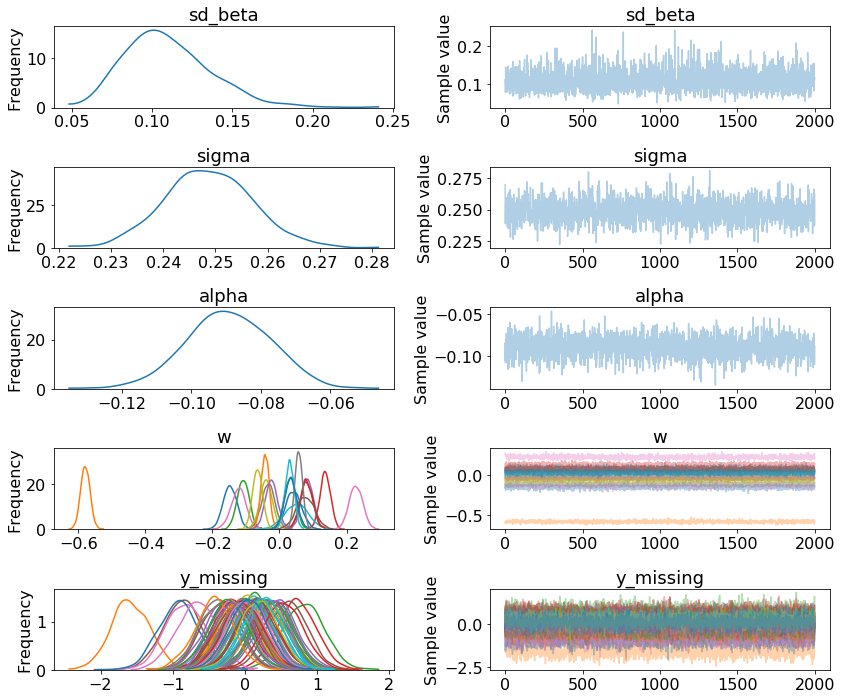

In [331]:
vars_ = ['sd_beta', 'sigma', 'alpha', 'w', 'y_missing']
mp_lasso_na_sub.evaluate_fit(vars_);


100%|██████████| 2000/2000 [00:01<00:00, 1599.69it/s]

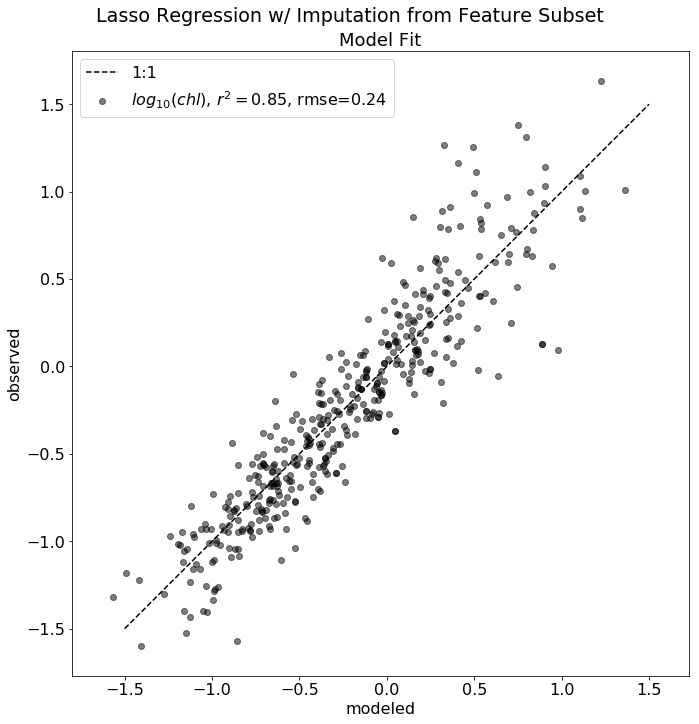

In [335]:
mp_lasso_na_sub.plot_model_fits(y_na, title='Lasso Regression w/ Imputation from Feature Subset');

In [154]:
with mpcap_lasso:
    inference=pm.ADVI()
    approx_lasso_pca_p = pm.fit(n=100000, method=inference,progressbar=False)

Finished [100%]: Average Loss = 77.134


In [155]:
tpcap_lasso = approx_lasso_pca_p.sample(2000)

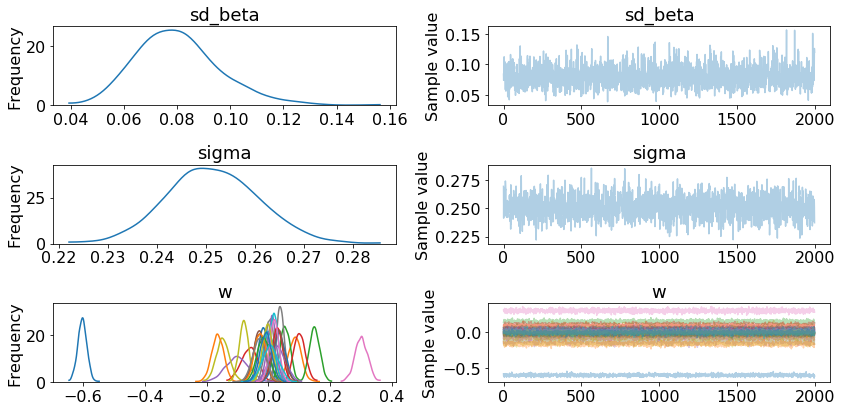

In [156]:
vars_ = ['sd_beta', 'sigma', 'w']
pm.traceplot(tpcap_lasso, varnames=vars_);

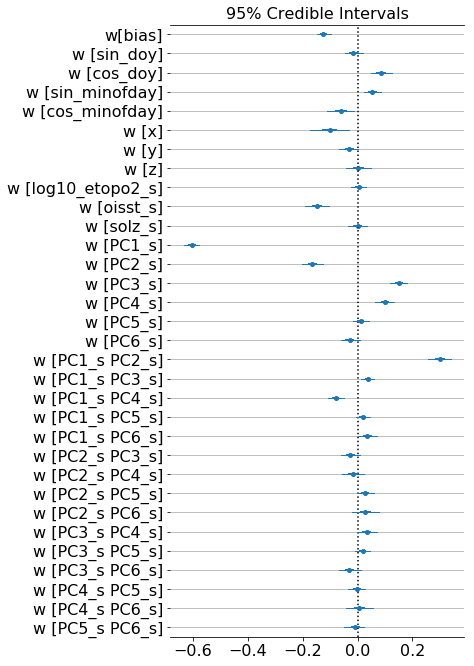

In [159]:
lbls = dpcapoly_s.loc[:, 'sin_doy':].columns.tolist()[:-1]
lbls_list = ['w[bias]']+['w [%s]' % lbl for lbl in lbls]
pm.forestplot(tpcap_lasso, varnames=['alpha', 'w'], ylabels=lbls_list);
f = pl.gcf()
f.set_figheight(10)
a = f.get_axes()[0]
a.grid(axis='y')

100%|██████████| 2000/2000 [00:01<00:00, 1612.76it/s]


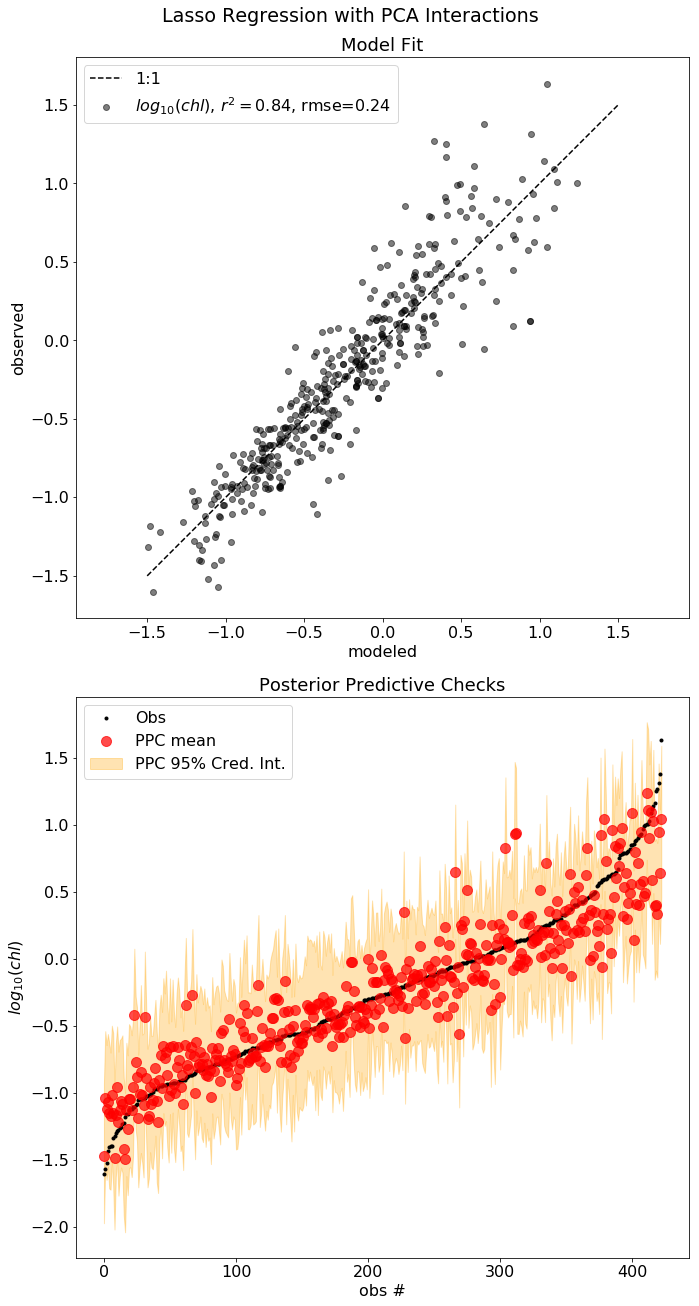

In [160]:
title = 'Lasso Regression with PCA Interactions'
ax1lps = Plot_Model_Fits(tpcap_lasso, mpcap_lasso, title=title)

In [247]:
hi, lo = 100*(1 - 0.05/2), 100*( 0 + 0.05/2)

In [248]:
f'hpd_{hi}'

'hpd_97.5'

In [238]:
vars_ = ['sd_beta', 'sigma', 'alpha', 'w']
dpcap_lasso = pm.summary(tpcap_lasso, varnames=vars_)
lbls = dpcapoly_s.loc[:, 'sin_doy':].columns.tolist()[:-1]
lbls_list = ['w [%s]' % lbl for lbl in lbls]
dpcap_lasso.index = ['sd_beta', 'sigma', 'alpha'] + lbls_list
dpcap_lasso_subset = dpcap_lasso[(((dpcap_lasso['hpd_2.5']<0)&(dpcap_lasso['hpd_97.5']<0))|
                    ((dpcap_lasso['hpd_2.5']>0) & (dpcap_lasso['hpd_97.5']>0))
                   )]

In [246]:
vars_[:-1]

['sd_beta', 'sigma', 'alpha']

In [261]:
pca_sub_lbls = subset_significant_feature(tpcap_lasso, lbls_Xpcap_s, beg_feat=feat_beg)

In [262]:
Xpcap_sub = dpcapoly_s.loc[:, pca_sub_lbls].values

In [264]:
Xpcap_s_na.shape

(494, 31)

In [267]:
mpcap_lasso_sub = PyMCModel(lasso_regression, Xpcap_sub, y_na,
                            model_name='lasso_w_pca_inter_sub.')


In [268]:
mpcap_lasso_sub.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, w, alpha, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:08<00:00, 1138.95draws/s]


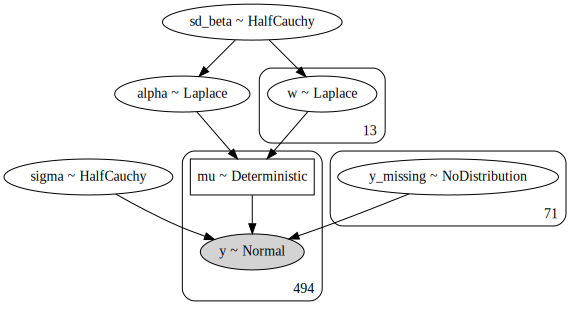

In [270]:
mpcap_lasso_sub.show_model()

In [271]:
mpcap_lasso_sub.trace_.varnames

['sd_beta_log__',
 'sigma_log__',
 'alpha',
 'w',
 'y_missing',
 'sd_beta',
 'sigma',
 'mu']

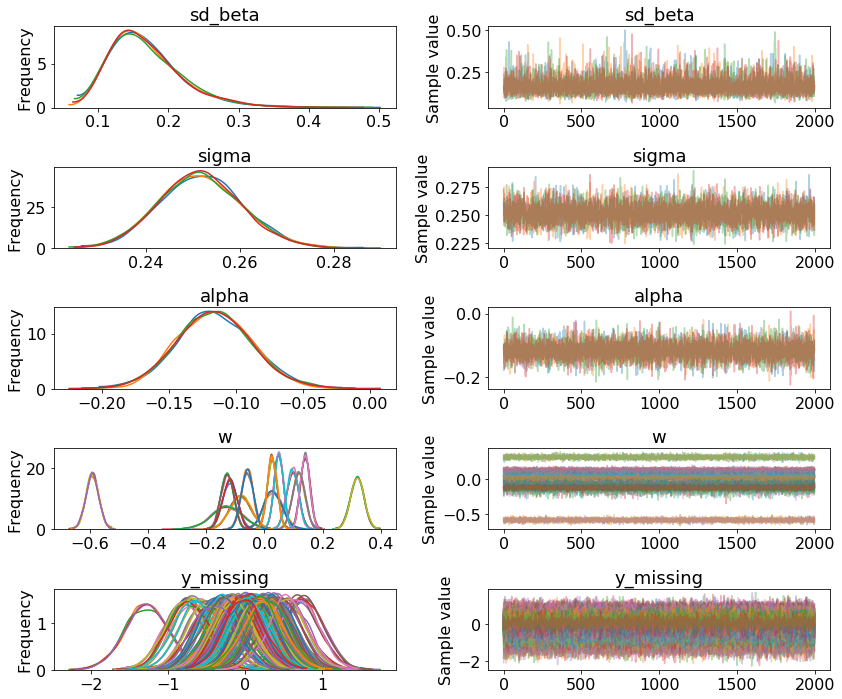

In [273]:
vars_ = ['sd_beta', 'sigma', 'alpha', 'w', 'y_missing']
mpcap_lasso_sub.evaluate_fit(vars_);

100%|██████████| 2000/2000 [00:01<00:00, 1616.40it/s]


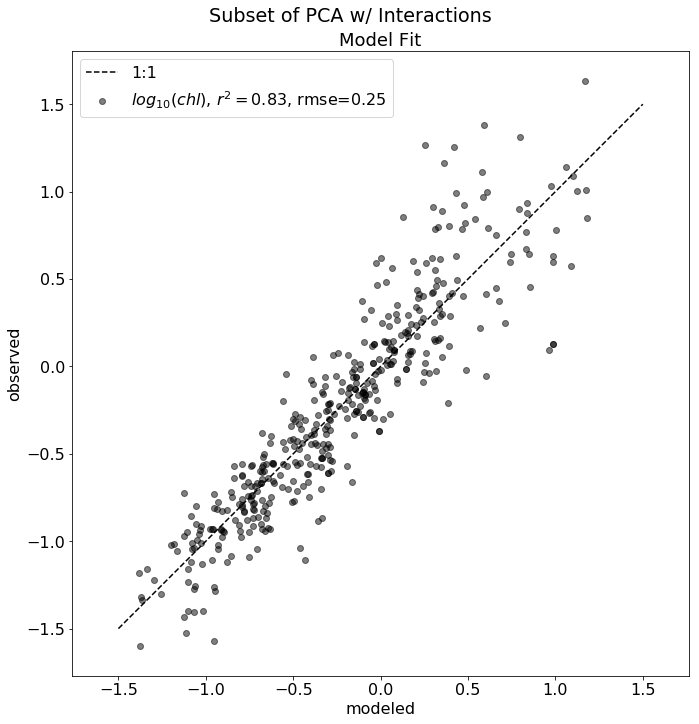

In [274]:
mpcap_lasso_sub.plot_model_fits(y_na, title='Subset of PCA w/ Interactions')

In [167]:
m_lasso_.model.name = 'lasso'

In [169]:
mpcap_lasso.name = 'lasso_w_pca_inter.'

In [170]:
mp_lasso.name = 'lasso_w_inter.'

In [276]:
mpcap_lasso_sub.model.name

'lasso_w_pca_inter_sub.'

In [278]:
mod_dict = {m_lasso_.model: m_lasso_.trace_,
            mpcap_lasso_sub.model: mpcap_lasso_sub.trace_,
           mp_lasso: tp_lasso, #mpcap_lasso: tpcap_lasso
           }
pm.compare(mod_dict)

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """

WAIC   pWAIC   dWAIC weight     SE    dSE var_warn
lasso_w_pca_inter_sub.   49.47   16.97       0   0.96  41.24      0        1
lasso_w_inter.           149.6  105.08  100.12      0  38.48  19.41        1
lasso                   223.68   18.89   174.2   0.04  33.52  25.06        1

In [279]:
pm.compare(mod_dict, ic='LOO')

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO    pLOO    dLOO weight     SE    dSE shape_warn
lasso_w_pca_inter_sub.  49.78   17.12       0   0.96  41.27      0          0
lasso_w_inter.            207  133.79  157.23      0  46.47  29.72          1
lasso                   223.9      19  174.13   0.04  33.55  25.11          0